# Part 4, Models Stacking and Validation

In [1]:
import tensorflow as tf
#tf.python.control_flow_ops = tf

import pickle
import xgboost as xgb
import pandas as pd
import numpy as np
import sys
_stdout = sys.stdout

sys.path.append('modules')

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from scipy.sparse import csr_matrix, hstack
from scipy.stats import iqr
from sklearn.model_selection import KFold, train_test_split
from keras.models import Sequential
from keras.layers.advanced_activations import PReLU
from keras.layers import Dense, Dropout, Activation, BatchNormalization
from keras.callbacks import EarlyStopping
from xgboost import XGBRegressor
#from xgb_regressor import XGBoostRegressor
#from stacker import Stacker

%matplotlib inline

/Users/macssd/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# To follow conventional function names in sklearn, we implement fit and predict functions

def xg_eval_mae(yhat, dtrain):
    y = dtrain.get_label()
    return 'mae', mean_absolute_error(np.exp(y), np.exp(yhat))

class XGBoostRegressor(object):
    def __init__(self, **kwargs):
        self.params = kwargs
        if 'num_boost_round' in self.params:
            self.num_boost_round = self.params['num_boost_round']
        self.params.update({'silent': 1, 'objective': 'reg:linear', 'seed': 0})
        
    def fit(self, x_train, y_train):
        dtrain = xgb.DMatrix(x_train, y_train)
        self.bst = xgb.train(params=self.params, dtrain=dtrain, num_boost_round=self.num_boost_round,
                             feval=xg_eval_mae, maximize=False)
        
    def predict(self, x_pred):
        dpred = xgb.DMatrix(x_pred)
        return self.bst.predict(dpred)
    
    def kfold(self, x_train, y_train, nfold=5):
        dtrain = xgb.DMatrix(x_train, y_train)
        cv_rounds = xgb.cv(params=self.params, dtrain=dtrain, num_boost_round=self.num_boost_round,
                           nfold=nfold, feval=xg_eval_mae, maximize=False, early_stopping_rounds=10)
        return cv_rounds.iloc[-1,:]
    
    def plot_feature_importances(self):
        feat_imp = pd.Series(self.bst.get_fscore()).sort_values(ascending=False)
        feat_imp.plot(title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        
    def get_params(self, deep=True):
        return self.params
 
    def set_params(self, **params):
        self.params.update(params)
        return self

In [3]:
import xgboost as xgb
import pandas as pd
import numpy as np
import sys
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from scipy.sparse import csr_matrix, hstack
from sklearn.cross_validation import KFold, train_test_split
from keras.models import Sequential
from keras.layers.advanced_activations import PReLU
from keras.layers import Dense, Dropout, Activation, BatchNormalization
from keras.callbacks import EarlyStopping
from xgboost import XGBRegressor
#from xgb_regressor import XGBoostRegressor

class Stacker(object):
    def __init__(self, xgboost_func, mlp_func, train_path='train.csv', seed=0, test_size=0.25, **kwargs):
        self.seed = seed
        self.test_size = test_size
        self.xgboost_func = xgboost_func
        self.train_path = train_path
        self.mlp_func = mlp_func
        self.mlp_fit_kwargs = kwargs.get('mlp_fit_kwargs', {'nb_epoch': 30, 'batch_size': 128, 'verbose': 1})
        self.mlp_predict_kwargs = kwargs.get('mlp_predict_kwargs', {'batch_size': 256, 'verbose': 1})

    def stack_and_compare(self):
        xg_xtr, xg_xte, xg_ytr, xg_yte  = self.preprocess(encoding='label', transform_label=True)
        mlp_xtr, mlp_xte, mlp_ytr, mlp_yte = self.preprocess(encoding='one-hot', transform_label=False)
        
        assert mean_absolute_error(np.exp(xg_ytr), mlp_ytr) < 0.001 # Sanity check
        assert mean_absolute_error(np.exp(xg_yte), mlp_yte) < 0.001 # Sanity check

        xgb_folds = self.predict_folds(self.xgboost_func, xg_xtr, xg_ytr)
        mlp_folds = np.log(self.predict_folds(self.mlp_func, mlp_xtr, mlp_ytr, 
                           fit_kwargs=self.mlp_fit_kwargs, predict_kwargs=self.mlp_predict_kwargs))

        xgb_pred_hold = self.predict_holdout(self.xgboost_func, xg_xtr, xg_ytr, xg_xte)
        mlp_pred_hold = np.log(self.predict_holdout(self.mlp_func, mlp_xtr, mlp_ytr, mlp_xte, 
                               fit_kwargs=self.mlp_fit_kwargs, predict_kwargs=self.mlp_predict_kwargs))

        score_xgb, score_mlp = self.evaluate_estimators(xgb_pred_hold, mlp_pred_hold, xg_yte)
        print ('Single model performance:', 'xgb:', score_xgb, ',', 'mlp:', score_mlp)

        stacker = self.stack(xgb_folds, mlp_folds, xg_ytr)
        score_stacker = self.evaluate_stacker(stacker, xgb_pred_hold, mlp_pred_hold, xg_yte)

        print ({'xgb': score_xgb, 'mlp': score_mlp, 'stacker': score_stacker})
        return {'xgb': score_xgb, 'mlp': score_mlp, 'stacker': score_stacker}

    def preprocess(self, encoding='one-hot', transform_label=False):
        train = pd.read_csv(self.train_path)
        if transform_label: 
            train['loss'] = np.log(train['loss'])
        cat_features = [x for x in train.select_dtypes(include=['object']).columns if x not in ['id','loss']]
        if encoding == 'one-hot':
            train = pd.get_dummies(data=train, columns=cat_features)
        elif encoding == 'label':
            for c in range(len(cat_features)): train[cat_features[c]] = train[cat_features[c]].astype('category').cat.codes
        else:
            raise Exception("Correct value of 'encoding' is required. Possible values of encoding=['one-hot', 'label']")
        features = [x for x in train.columns if x not in ['id','loss']]
        train_x = np.array(train[features])
        train_y = np.array(train['loss'])
        x_tr, x_te, y_tr, y_te = train_test_split(train_x, train_y, test_size=self.test_size, random_state=self.seed)
        return x_tr, x_te, y_tr, y_te

    def predict_folds(self, model_func, xtrain, ytrain, fit_kwargs={}, predict_kwargs={}):
        folds = KFold(len(ytrain), shuffle=False, n_folds=3)
        fold_preds = np.zeros(len(ytrain))
        for k, (train_index, test_index) in enumerate(folds):
            xtr = xtrain[train_index]
            ytr = ytrain[train_index]
            estimator = model_func(xtrain.shape[1])
            xte, yte = xtrain[test_index], ytrain[test_index]
            estimator.fit(xtr, ytr, **fit_kwargs)
            fold_preds[test_index] = estimator.predict(xte, **predict_kwargs)
        return fold_preds

    def predict_holdout(self, model_func, xtrain, ytrain, xtest, fit_kwargs={}, predict_kwargs={}):
        estimator = model_func(xtrain.shape[1])
        estimator.fit(xtrain, ytrain, **fit_kwargs)
        return estimator.predict(xtest, **predict_kwargs)

    def evaluate_estimators(self, xgb_pred, mlp_pred, test_y):
        return mean_absolute_error(np.exp(xgb_pred), np.exp(test_y)), mean_absolute_error(np.exp(mlp_pred), np.exp(test_y))

    def stack(self, xgb_oof, mlp_oof, oof_y):
        assert len(xgb_oof) == len(mlp_oof)
        oof_x = np.vstack((xgb_oof, mlp_oof)).T
        metaestimator = LinearRegression()
        metaestimator.fit(oof_x, oof_y)
        return metaestimator

    def evaluate_stacker(self, stacker, xgb_pred, mlp_pred, holdout_y):
        holdout_pred = np.hstack((xgb_pred.reshape(len(xgb_pred), 1), np.array(mlp_pred)))
        predictions = stacker.predict(holdout_pred)
        score = mean_absolute_error(np.exp(predictions), np.exp(holdout_y))
        return score

/Users/macssd/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/macssd/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In the final part of this capstone, we implement a simple stacker model in which we generate predictions using two models: XGBoost and MLP. Then we combine them in a single dataset and train a second level algorithm to get the final prediction.

We are going to do a K-Fold stacking in which we train each model (level 0 model or just L0-model) on a subset of data, generate out-of-fold predictions and train the stacker (level 1 model, L1-model) on these predictions.

As usual, use can use pretrained models and skip the heavy computation phase:

In [4]:
USE_PRETRAINED = True

## Methodology

Our methodology which I took from [MLWave Ensembling Guide](http://mlwave.com/kaggle-ensembling-guide/) as well as from the winners of [Otto Group Classification Challenge](https://www.kaggle.com/c/otto-group-product-classification-challenge/forums/t/14335/1st-place-winner-solution-gilberto-titericz-stanislav-semenov) is as follows:

* **Splitting.** Split the training set into K folds


* **Out-of-fold predictions**. Fit each L0-model on K-1 folds, generate predictions for the other fold. Repeat the process for all K folds. In the end, we get predictions for the whole training set (for which we also have labels).


* **Fitting on the entire training set**. We fit each L0-model on the whole training set and get predictions for the test set. We combine predictions into a dataset, in which each feature is prediction of a single L0-model.


* **Training L1**. We fit L1-model on out-of-fold predictions, while using corresponding labels from the training set as labels for L1. After that, we ask the L1-model get the final prediction using our combine dataset of L0 predictions.

There is only one complication: we don't have the test set (we're not going to submit our prediction to Kaggle now), but we need to compare the performance of single L0-models with the stacker, as we'd like to make sure that L1-model works better than any of L0-models.

To do this, we split our training dataset into train and test subsets. We will touch the test subset only once when we compare the performance of all the models (L0 vs L1).



## Splitting

### Preparing the data
We trained our models on the same train set, but the preprocessing phase has been done differently for XGBoost and MLP. We have to replicate the same preprocessing for our ensemble phase. Let's revisit what we have to do for each model:

* **XGBoost**: 1) log-transform the target feature, 2) use a label encoding for categorical features.


* **MLP**: 1) use an one-hot encoding for categorical features.

I'll be verbose in this section and apply all the transformations manually without writing an abstraction (say, a function or a class). We only have two models and there's no need to abstract the logic in our case.

In [5]:
# XGBoost

trainxg = pd.read_csv('./data/train.csv')
ntrain = trainxg.shape[0]

trainxg['log_loss'] = np.log(trainxg['loss'])    
features = [x for x in trainxg.columns if x not in ['id','loss', 'log_loss']]

cat_features = [x for x in trainxg.select_dtypes(
        include=['object']).columns if x not in ['id','loss', 'log_loss']]

for c in range(len(cat_features)):
    trainxg[cat_features[c]] = trainxg[cat_features[c]].astype('category').cat.codes

trainxg_x = np.array(trainxg[features])
trainxg_y = np.array(trainxg['log_loss'])

# xg_xte, xg_yte are for the final performance check
xg_xtr, xg_xte, xg_ytr, xg_yte = train_test_split(trainxg_x, trainxg_y, test_size=0.25, random_state=31337)

print ("Let's see that we haven't messed up with data split:")
print ("Training set X:", xg_xtr.shape, "Y:", xg_ytr.shape)
print ("Test set X:", xg_xte.shape, "Y:", xg_yte.shape)

Let's see that we haven't messed up with data split:
Training set X: (141238, 130) Y: (141238,)
Test set X: (47080, 130) Y: (47080,)


In [6]:
# MLP

trainmlp = pd.read_csv('./data/train.csv')
cat_names = [c for c in trainmlp.columns if 'cat' in c]

trainmlp = pd.get_dummies(data=trainmlp, columns=cat_names)

features_mlp = [x for x in trainmlp.columns if x not in ['id','loss']]

trainmlp_x = np.array(trainmlp[features_mlp])
trainmlp_y = np.array(trainmlp['loss'])

mlp_xtr, mlp_xte, mlp_ytr, mlp_yte = train_test_split(trainmlp_x, trainmlp_y, test_size=0.25, random_state=31337)

print ("Let's see that we haven't messed up with data split:")
print ("Training set X:", mlp_xtr.shape, "Y:", mlp_ytr.shape)
print ("Test set X:", mlp_xte.shape, "Y:", mlp_yte.shape)

Let's see that we haven't messed up with data split:
Training set X: (141238, 1153) Y: (141238,)
Test set X: (47080, 1153) Y: (47080,)


### Preparing the L0-models

Now we just take our final models for XGBoost and MLP. Of course, we could have found more models to add to the stacker.

In [7]:
# XGBoost

reg_xgb = XGBoostRegressor(num_boost_round=200, eta=0.07, gamma=0.2, max_depth=8, min_child_weight=6,
                colsample_bytree=0.6, subsample=0.9)

In [8]:
# MLP

def hyper_model():
    model = Sequential()
    model.add(Dense(351, input_dim=len(features_mlp), init='glorot_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.578947))
    
    model.add(Dense(293, init='glorot_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.26666))
    
    model.add(Dense(46, init='glorot_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.188888))
    
    model.add(Dense(1, init='glorot_normal'))
    model.compile(loss='mae', optimizer='adadelta')
    return model

## Out-of-fold predictions

Now we divide our training set `xg_xtr, xg_ytr` (xgboost), `mlp_xtr, mlp_ytr` (mlp) into k-folds (3), train on 2/3 folds and predict the third fold. We persist the results to files to get back to them later on.

We also save test labels (`*_test_fold_*`) to make sure that the fold generator splits data the same fashion for XGBoost and MLP and we can stack their predictions side by side.

In [9]:
# XGBoost
if not USE_PRETRAINED:
    folds = KFold(len(xg_ytr), shuffle=False, n_folds=3)

    for k, (train_index, test_index) in enumerate(folds):
        xtr = xg_xtr[train_index]
        ytr = xg_ytr[train_index]
        xte, yte = xg_xtr[test_index], xg_ytr[test_index]
        reg_xgb = XGBoostRegressor(num_boost_round=200, eta=0.09, gamma=0.1, max_depth=8, min_child_weight=6,
                        colsample_bytree=0.9, subsample=0.8)
        reg_xgb.fit(xtr, ytr)
        np.savetxt('ensemble/xgb_pred_fold_{}.txt'.format(k), np.exp(reg_xgb.predict(xte)))
        np.savetxt('ensemble/xgb_test_fold_{}.txt'.format(k), yte)

In [10]:
# MLP
if not USE_PRETRAINED:
    folds = KFold(len(mlp_ytr), shuffle=False, n_folds=3)
    for k, (train_index, test_index) in enumerate(folds):
        xtr = mlp_xtr[train_index]
        ytr = mlp_ytr[train_index]
        xte, yte = mlp_xtr[test_index], mlp_ytr[test_index]
        reg_mlp = hyper_model()
        fit = reg_mlp.fit(xtr, ytr, batch_size=128, nb_epoch=30, verbose=0)
        pred = reg_mlp.predict(xte, batch_size=256)
        np.savetxt('ensemble/mlp_pred_fold_{}.txt'.format(k), pred)
        np.savetxt('ensemble/mlp_test_fold_{}.txt'.format(k), yte)

## Training on the whole dataset

We train the same models on the whole training set (`xg_xtr, mlp_xtr` and corresponding labels) and generate predictions for the test set (`xg_xte, mlp_xte`). Remember that we do have labels for the test set, but we don't allow our L0-model see them.

In [11]:
# XGBoost
if not USE_PRETRAINED:
    reg_xgb = XGBoostRegressor(num_boost_round=200, eta=0.09, gamma=0.1, max_depth=8, min_child_weight=6,
                  colsample_bytree=0.9, subsample=0.8)
    reg_xgb.fit(xg_xtr, xg_ytr)
    np.savetxt('ensemble/xgb_pred_test.txt'.format(k), np.exp(reg_xgb.predict(xg_xte)))

In [12]:
# MLP
if not USE_PRETRAINED:
    reg_mlp = hyper_model()
    fit = reg_mlp.fit(mlp_xtr, mlp_ytr, batch_size=128, nb_epoch=30, verbose=0)
    pred = reg_mlp.predict(mlp_xte, batch_size=256)
    np.savetxt('ensemble/mlp_pred_test.txt'.format(k), pred)

## L1-model training

When the previous stage is completed, we have generated out-of-fold and test set predictions, which we can now use to train the stacker.

First, we load predictions:

In [13]:
train_xgb1 = np.loadtxt('ensemble/xgb_pred_fold_0.txt')
train_xgb2 = np.loadtxt('ensemble/xgb_pred_fold_1.txt')
train_xgb3 = np.loadtxt('ensemble/xgb_pred_fold_2.txt')

train_mlp1 = np.loadtxt('ensemble/mlp_pred_fold_0.txt')
train_mlp2 = np.loadtxt('ensemble/mlp_pred_fold_1.txt')
train_mlp3 = np.loadtxt('ensemble/mlp_pred_fold_2.txt')

### Sanity check \#1
We load labels to check that we haven't messed up with folds:

In [14]:
xgb_test_fold1 = np.exp(np.loadtxt('ensemble/xgb_test_fold_0.txt'))
xgb_test_fold2 = np.exp(np.loadtxt('ensemble/xgb_test_fold_1.txt'))
xgb_test_fold3 = np.exp(np.loadtxt('ensemble/xgb_test_fold_2.txt'))

mlp_test_fold1 = np.loadtxt('ensemble/mlp_test_fold_0.txt')
mlp_test_fold2 = np.loadtxt('ensemble/mlp_test_fold_1.txt')
mlp_test_fold3 = np.loadtxt('ensemble/mlp_test_fold_2.txt')

In [15]:
# Recreating the original set of training set labels:

xgb_test_fold = np.hstack((xgb_test_fold1, xgb_test_fold2, xgb_test_fold3))
mlp_test_fold = np.hstack((mlp_test_fold1, mlp_test_fold2, mlp_test_fold3))

In [16]:
# And testing that these labels completely match (there's still a little rounding error due to log-exp conversion):

mean_absolute_error(xgb_test_fold, mlp_test_fold)

1.1180932118489165e-12

### This is basically zero. Labels from two fold generators match and we can go on.

### Sanity check \#2

Now we load the predictions for the whole test set:

In [17]:
test_xgb = np.loadtxt('ensemble/xgb_pred_test.txt')
test_mlp = np.loadtxt('ensemble/mlp_pred_test.txt')

### We should check that MAE from combined out-of-fold predictions is reasonable:

In [18]:
# Combined out-of-fold predictions for XGBoost and MLP

train_xgb_folds = np.hstack((train_xgb1, train_xgb2, train_xgb3))
train_mlp_folds = np.hstack((train_mlp1, train_mlp2, train_mlp3))

In [19]:
# MAE of XGBoost combined predictions

mean_absolute_error(np.exp(xg_ytr), train_xgb_folds)

1155.1388944371015

In [20]:
# MAE of MLP combined predictions

mean_absolute_error(mlp_ytr, train_mlp_folds)

1147.367184299818


Predictions are around 1150-1155: this is exactly what we expect from these models.

We do the same for the test set and get scores for each single model. The score of the best single model is our baseline score for the stacker (our stacker should perform better than any given single model).

In [21]:
mae_xgb_test = mean_absolute_error(np.exp(xg_yte), test_xgb)
mae_mlp_test = mean_absolute_error(mlp_yte, test_mlp)
print ("Baseline MAE which we need to improve with stacking, XGB: {}; MLP: {}.".format(mae_xgb_test, mae_mlp_test))

Baseline MAE which we need to improve with stacking, XGB: 1152.2006603472637; MLP: 1148.0359189095834.


Predictions on test should be close to 1145-1150.

### Training L1-model

Finally, it's time to join the predictions of L0-models and train a stacker over them.

In [22]:
l1_train_x = np.vstack((train_xgb_folds, train_mlp_folds)).T
l1_test_x = np.vstack((test_xgb, test_mlp)).T
l1_train_y = mlp_ytr
l1_test_y = mlp_yte

In [23]:
# Just a sanity check
print ("Xtrain shape:", l1_train_x.shape)
print ("ytrain shape:", l1_train_y.shape)
print ("Xtest shape:", l1_test_x.shape)
print ("ytest shape:", l1_test_y.shape)

Xtrain shape: (141238, 2)
ytrain shape: (141238,)
Xtest shape: (47080, 2)
ytest shape: (47080,)


The choice of the algorithm for L1 is crucial. The problem is that we don't want it overfit on the training set, and it can be very easily done. To reduce the possibility of overfitting, we should take a very simple regressor, and LinearRegression is the ideal candidate for us.

We now fit a very basic linear regression and get the predictions for the final test set:

In [103]:
reg = LinearRegression()

# Note that normalizing the data in case of linear models is very important
reg.fit(np.log(l1_train_x), np.log(l1_train_y))
pred = reg.predict(np.log(l1_test_x))


print(l1_train_x, l1_train_y, l1_test_x, pred)

[[1020.42718506  999.43988037]
 [1167.49963379 1045.68322754]
 [1069.88916016 1060.41333008]
 ...
 [3103.23144531 2856.31298828]
 [2170.16210938 1978.93310547]
 [1309.57043457 1438.5657959 ]] [ 986.06 1753.14 1792.7  ... 3394.84 1587.2  1602.7 ] [[2618.94726562 2671.17944336]
 [2938.3972168  3014.97021484]
 [1104.91955566 1443.08862305]
 ...
 [3623.34277344 3300.77807617]
 [1988.98425293 2522.15234375]
 [ 581.17321777  847.07281494]] [  47.20170534   71.47767004 -134.8282622  ...  115.67379634  -10.83454155
 -270.34439429]


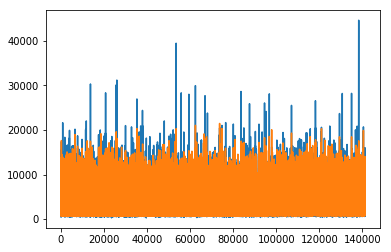

In [104]:
plt.plot(l1_train_x)
plt.show()

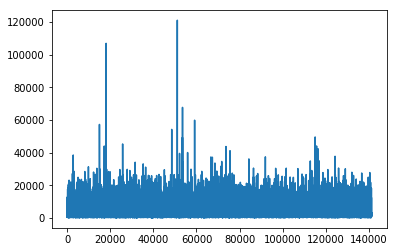

In [105]:
plt.plot(l1_train_y)
plt.show()

In [89]:
reg = LinearRegression()

# Note that normalizing the data in case of linear models is very important
reg.fit(l1_train_x, l1_train_y)
pred = reg.predict(l1_test_x)

print(l1_train_x, l1_train_y, l1_test_x, pred)

[[1020.42718506  999.43988037]
 [1167.49963379 1045.68322754]
 [1069.88916016 1060.41333008]
 ...
 [3103.23144531 2856.31298828]
 [2170.16210938 1978.93310547]
 [1309.57043457 1438.5657959 ]] [ 986.06 1753.14 1792.7  ... 3394.84 1587.2  1602.7 ] [[2618.94726562 2671.17944336]
 [2938.3972168  3014.97021484]
 [1104.91955566 1443.08862305]
 ...
 [3623.34277344 3300.77807617]
 [1988.98425293 2522.15234375]
 [ 581.17321777  847.07281494]] [-5.96727313e+28  4.24492733e+29 -1.78960940e+30 ...  8.27448533e+29
 -2.70075348e+29 -2.62895483e+30]


In [63]:
print(np.log(l1_train_x), np.log(l1_train_y), np.log(l1_test_x), pred)

[[6.92797663 6.907195  ]
 [7.06261968 6.95242576]
 [6.97531033 6.96641405]
 ...
 [8.04019925 7.95728691]
 [7.68255715 7.59031314]
 [7.17745445 7.27140192]] [6.8937172  7.46916374 7.49147814 ... 8.13001191 7.36972674 7.37944499] [[7.87052771 7.89027539]
 [7.98561955 8.01134523]
 [7.00752781 7.27454097]
 ...
 [8.1951523  8.1019135 ]
 [7.59537936 7.83286792]
 [6.36504885 6.74178666]] [-4.24358289e+11 -6.90736526e+11  1.14078211e+12 ... -9.83537493e+11
 -1.30911949e+11  2.41602495e+12]


In [25]:
mae_stacker = mean_absolute_error(l1_test_y, np.exp(pred))

print ("MAE for XGB:", mae_xgb_test)
print ("MAE for MLP:", mae_mlp_test)
print ("MAE for stacker:", mae_stacker)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').